In [27]:
################################################################
### Implement a Classifier for the CIFAR10 data set
################################################################

# Import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

# Define a function to look at CIFAR10 images
def imshow(img):
    # Unnormalize the images
    img = img / 2 + 0.5
    
    # Make the image a numpy array
    np_img = img.numpy()
    
    # Show the image
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


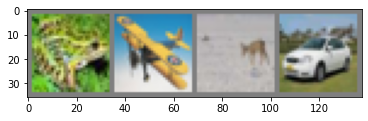

frog plane deer car


In [61]:
# LOAD THE DATA
# Set a random seed
torch.manual_seed(42)

# Define the batch size
batch_size = 4

# Define the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define a transformer
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the training data
train_set = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Load the test data
test_set = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Sanity check the iterator
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Show images obtained from iterator
imshow(torchvision.utils.make_grid(images))
print(' '.join([f'{classes[label]}' for label in labels]))



In [40]:
# DEFINE NETWORK
class Net(nn.Module):
    def __init__(self):
        # Initialize the parent/super class
        super().__init__()
        
        # Define the different layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network
net = Net()

# Define a loss (Cross Entropy because its a classification problem)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


torch.Size([4, 10])


In [47]:
# TRAINING
num_epochs = 2
start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # Get the input images and the labels
        inputs, labels = data

        # Zero the parameters' gradients
        # Remark: This is needed because subsequent calls to loss.backward() will accumulate
        #         the gradients (over the batches)... This is because accumulation is needed
        #         for RNNs and hence the accumulation is the default...
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = net(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        # Remark: This will automatically set all the gradients for each of the parameters
        loss.backward()
        
        # Make an optimizer step
        optimizer.step()
        
        # Print the statistics
        running_loss += loss.item()
        if i%2000 == 1999:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss/2000}")
            running_loss = 0.0

print(f'Finished Training (Duration: {(time.time()-start_time)/60:.2f} min)')
        

[1, 2000] loss: 1.4574320482462644
[1, 4000] loss: 1.4037472603023051
[1, 6000] loss: 1.4009988518580794
[1, 8000] loss: 1.3704202223047615
[1, 10000] loss: 1.3310190956294536
[1, 12000] loss: 1.3081446677073836
[2, 2000] loss: 1.256315937485546
[2, 4000] loss: 1.2289770265184343
[2, 6000] loss: 1.236145457793027
[2, 8000] loss: 1.2116783772297204
[2, 10000] loss: 1.1970573379211127
[2, 12000] loss: 1.2071515300571918
Finished Training (Duration: 3.80 min)


In [48]:
# Store the trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

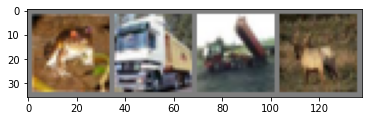

frog truck truck deer
cat truck truck deer


In [53]:
##############################################
# Evaluate the model for some test data
##############################################
# Get some test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Show some images
imshow(torchvision.utils.make_grid(images))
print(' '.join([f'{classes[label]}' for label in labels]))

# Load the net
net = Net()
net.load_state_dict(torch.load(PATH))

# Generate the outputs
outputs = net(images)

# Get the predicted labels (shape [#datapoints_per_batch, #features]) which are the maximal 
# feature value for each data point
predicted_labels = torch.argmax(outputs, 1)
print(' '.join([f'{classes[label]}' for label in predicted_labels]))

In [57]:
##############################################
# Evaluate performance of the whole test set
##############################################
correct = 0
total = 0

# We are not training and hence do not use gradients
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        predicted_labels = torch.argmax(outputs, 1)
        
        # Get #datapoints_per_batch
        total += labels.size(0)
        
        # Get the number of correct labels
        correct += (predicted_labels==labels).sum().item()

print(f"Accuracy of the network on 10000 test samples is {100*correct/total}%")

Accuracy of the network on 10000 test samples is 61.492%


In [60]:
#################################################
# Evaluate prediction per class for the test set
#################################################
# Initialize dictionaries that will contain the number of
# correct and total predictions for each class, which will
# be updated below
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# No training, no gradients
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        predicted_labels = torch.argmax(outputs, 1)
        
        # Run over the labels an check if it matches the prediction
        # => Add to the key-value pair if it does
        for label, predicted_label in zip(labels, predicted_labels):
            if label==predicted_label:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print the accuracy per class
for classname, correct_count in correct_pred.items():
    accuracy = 100*float(correct_count)/total_pred[classname]
    print(f"Accuracy for class {classname}: {accuracy}%")


Accuracy for class plane: 69.48%
Accuracy for class car: 70.26%
Accuracy for class bird: 44.3%
Accuracy for class cat: 39.58%
Accuracy for class deer: 47.28%
Accuracy for class dog: 65.14%
Accuracy for class frog: 74.94%
Accuracy for class horse: 63.54%
Accuracy for class ship: 73.64%
Accuracy for class truck: 66.76%
